# Data fitting test for no shuttling 9-ion rabi oscillation with 300us delay

In [2]:
from qutip import *
from scipy.optimize import curve_fit
import math
import cmath
import timeit
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from time import time 
from pynverse import inversefunc
from mpl_toolkits.axisartist.axislines import SubplotZero
import matplotlib
import h5py as h5
from scipy.special import laguerre
from scipy.integrate import dblquad, quad
import scipy

# Update matplotlib settings for consistent appearance in plots
matplotlib.rcParams.update(
    {"font.family": "STIXGeneral",
     "xtick.labelsize": 12,
     "xtick.direction": "in",
     "xtick.major.pad": 3,
     "xtick.top": True,
     "ytick.labelsize": 12,
     "ytick.direction": "in",
     "ytick.right": True,
     "axes.labelsize": 12,
     "axes.labelpad": 3,
     "axes.grid": True
    }
)

# File loading function
def file_loading(data_path, date, index, number, x='rabi_t', y='pmt_counts_avg_thresholded', exp='RabiTimeScan'):
    # Construct full file path
    file_path = data_path + date + index + f"/0000{number}-" + exp + ".h5"
    # For debugging or direct file usage, you can hardcode file_path if needed.
    # file_path = data_path  # If you directly used a fixed path
    
    with h5.File(file_path, "r") as file:
        datasets_keys = list(file['datasets'].keys())
        print("Datasets available:", datasets_keys)
        x_data = file['datasets'][x][:]
        y_data = file['datasets'][y][:]
        
    return x_data, y_data, np.linspace(np.min(x_data), np.max(x_data), 300)


###########################################
# Load and preprocess the data
###########################################

n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "19"
number = 30462

# data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
# date = "2024-10-27/"
# number = 30462
# file_path = data_path + date + f"19/0000{number}-RabiTimeScan.h5"

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded)

###########################################
# Define the model and fit parameters
###########################################

n_ions = 9
N = 300

def pe_model_optimized(time, rabi_0_fit, nbar_fit, nalpha_fit):
    ndisplace_fit = complex(0, np.sqrt(nalpha_fit))
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9

def pe_model_optimized_fitting(time, rabi_0_fit, nbar_fit, nalpha_fit):
    ndisplace_fit = complex(0, np.sqrt(nalpha_fit))
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = 0
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9

# Wrapper for curve_fit
def fit_model(time, rabi_0_fit, nbar_fit, nalpha_fit):
    return pe_model_optimized_fitting(time, rabi_0_fit, nbar_fit, nalpha_fit)

# Initial guesses
initial_guess = [0.1, 30, 0.0]  # [rabi, nbar, nalpha]
bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


Fitted parameters:
rabi =  0.09831967172293068
nbar =  21.239449668623863
nalpha =  0.9999999995777552


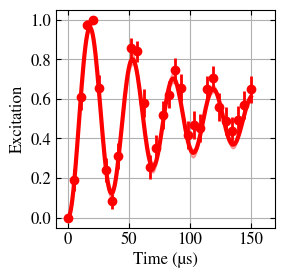

In [3]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
n_ions = 9
N = 300
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 6.00 kHz shuttling speed

In [5]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "20"
number = 30524

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.2

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 80), (0.12, 2, 130))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


Fitted parameters:
rabi =  0.09964254838798685
nbar =  1.999999993934203
nalpha =  122.34406667744291


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\qutip\core\states.py:528: RuntimeWarning: overflow encountered in exp
  diags = np.exp(-beta * i)
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\qutip\core\states.py:529: RuntimeWarning: invalid value encountered in divide
  diags = diags / np.sum(diags)


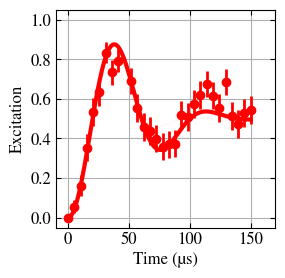

In [6]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
n_ions = 9
N = 300
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 6.02 kHz shuttling speed

In [7]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "20"
number = 30534

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [-12]  # Added 12 to the list
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.3

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 80), (0.12, 3, 200))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


Fitted parameters:
rabi =  0.1199999999999988
nbar =  2.999999999999962
nalpha =  166.4967161342865


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\qutip\core\states.py:527: RuntimeWarning: invalid value encountered in log
  beta = np.log(1.0 / n + 1.0)


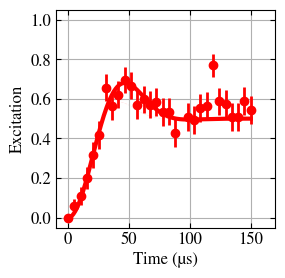

In [8]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
n_ions = 9
N = 300
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 6.01 kHz shuttling speed

In [9]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "20"
number = 30542

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]  # Added 12 to the list
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.2

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 80), (0.12, 2.5, 200))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


Fitted parameters:
rabi =  0.10147100137496974
nbar =  2.4999999999582383
nalpha =  124.75619361877602


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\qutip\core\states.py:527: RuntimeWarning: invalid value encountered in log
  beta = np.log(1.0 / n + 1.0)


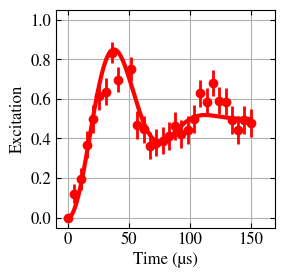

In [10]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
n_ions = 9
N = 300
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 6.20 kHz shuttling speed

In [11]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "20"
number = 30522

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]  # Added 12 to the list
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.1

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 100), (0.12, 1, 200))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


Fitted parameters:
rabi =  0.11999999999999193
nbar =  0.24644548668288463
nalpha =  182.60730811877895


c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
c:\Users\bingr\.conda\envs\physics\Lib\site-packages\scipy\special\_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for


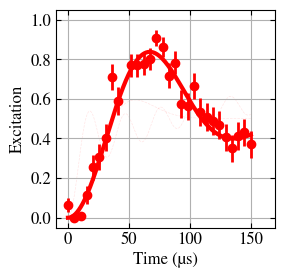

In [12]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
n_ions = 9
N = 300
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
# plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 6.38 kHz shuttling speed

In [6]:
n_ions = 9
N = 400

def pe_model_optimized(time, rabi_0_fit = rabi, nbar_fit = nbar, nalpha_fit = nalpha):
    ndisplace_fit = complex(0, np.sqrt(nalpha_fit))
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = np.zeros_like(time)
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9, diagonal_elements_all / 9

def pe_model_optimized_fitting(time, rabi_0_fit, nbar_fit, nalpha_fit):
    ndisplace_fit = complex(0, np.sqrt(nalpha_fit))
    intensity_distribution = np.array([0.96912696, 0.9844114, 0.99344862, 0.99840835, 1., 0.99840835, 0.99344862, 0.9844114, 0.96912696])
    pe_fit = 0
    diagonal_elements_all = np.zeros(N)
    for k in range(len(intensity_distribution)):
        if(k < 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += 2 * diagonal_elements
            for i in range(N):
                pe_fit += 2 * diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
        elif(k == 4):
            eta = 0.23/np.sqrt(n_ions)    # LD parameter
            eta_squared_laguerre_values = [laguerre(i)(eta**2) for i in range(N)]
            inputstate_fit = displace(N, ndisplace_fit) * thermal_dm(N, nbar_fit) * displace(N, ndisplace_fit).dag()
            diagonal_elements = np.abs(inputstate_fit.full().diagonal())
            diagonal_elements_all += diagonal_elements
            for i in range(N):
                pe_fit += diagonal_elements[i] * np.sin(intensity_distribution[k] * rabi_0_fit * eta_squared_laguerre_values[i] * time)**2
    return pe_fit / 9

# Wrapper for curve_fit
def fit_model(time, rabi_0_fit, nbar_fit, nalpha_fit):
    return pe_model_optimized_fitting(time, rabi_0_fit, nbar_fit, nalpha_fit)

In [7]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "20"
number = 30516

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]  # Added 12 to the list
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.3

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 200), (0.2, 2, 300))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountere

Fitted parameters:
rabi =  0.19579199998431665
nbar =  1.893232511519885e-10
nalpha =  277.12627343641685


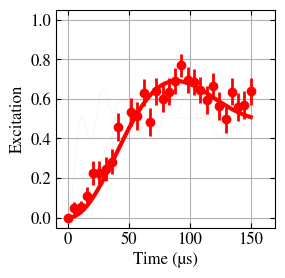

In [8]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
# n_ions = 9
# N = 400
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
# plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 5.90 kHz shuttling speed

In [9]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "20"
number = 30528

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]  # Added 12 to the list
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.3

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 100), (0.15, 2, 300))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountere

Fitted parameters:
rabi =  0.14057883220983147
nbar =  7.135256133998461e-11
nalpha =  213.9525154036317


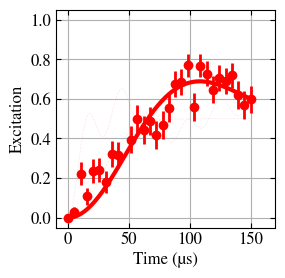

In [10]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
# n_ions = 9
# N = 400
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
# plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 4.80 kHz shuttling speed

In [17]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "20"
number = 30574

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]  # Added 12 to the list
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.3

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 100), (0.14057883220983147, 2, 300))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountere

Fitted parameters:
rabi =  0.1405788322069441
nbar =  0.7778329828397549
nalpha =  190.2415382148226


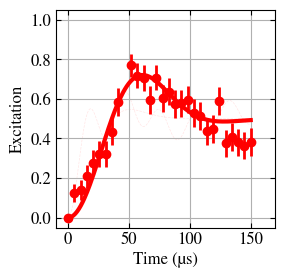

In [18]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
# n_ions = 9
# N = 400
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
# plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 4.763 kHz shuttling speed

In [19]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "19"
number = 30424

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [9]  # Added 12 to the list
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.3

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 100), (0.14057883220983147, 2, 300))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountere

Fitted parameters:
rabi =  0.10986807968457338
nbar =  1.9999999999992386
nalpha =  140.90956896854001


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/qutip/core/states.py:487: RuntimeWarning: overflow encountered in exp
  diags = np.exp(-beta * i)
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/qutip/core/states.py:488: RuntimeWarning: invalid value encountered in divide
  diags = diags / np.sum(diags)


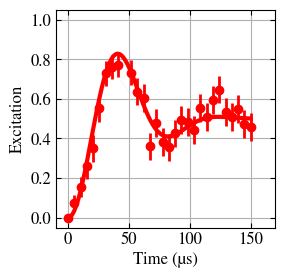

In [20]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
# n_ions = 9
# N = 400
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
# plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()

# Shuttling data with 4.762 kHz shuttling speed

In [23]:
n_samples = 50

# Specify the data path and file details
data_path = "/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/artiq_working_dir - 20240329/"
date = "2024-10-27/"
index = "19"
number = 30412

rabi_t, pmt_counts_avg_thresholded, times = file_loading(data_path, date, index, number)
rabi_t = np.array(rabi_t)  # Convert list to numpy array if not already
pmt_counts_avg_thresholded = np.array(pmt_counts_avg_thresholded)

# Remove unwanted indices if needed
indices_to_remove = [-7, -8, -9]  # Added 12 to the list
keep_indices = np.ones(len(rabi_t), dtype=bool)  # Initially set all to True
keep_indices[indices_to_remove] = False
rabi_t = rabi_t[keep_indices]
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded[keep_indices]

# Data re-scaling
errorbar = (np.sqrt(pmt_counts_avg_thresholded) / np.sqrt(n_samples)) / np.max(pmt_counts_avg_thresholded)
pmt_counts_avg_thresholded = np.max(pmt_counts_avg_thresholded) - pmt_counts_avg_thresholded
pmt_counts_avg_thresholded = pmt_counts_avg_thresholded / np.max(pmt_counts_avg_thresholded) / 1.3

# Initial guesses
# initial_guess = [0.09832203238100552, 0, 100]  # [rabi, nbar, nalpha]
# bounds = ((0.05, 0, 0), (0.15, 30, 1))  # Modified upper bound for nalpha to 5
bounds = ((0.07, 0, 100), (0.14057883220983147, 2, 300))
# bounds = ((0.0, 0, 0), (0.15, np.inf, np.inf))
# Initial guess is the center of the bounds
initial_guess = [(bounds[0][0] + bounds[1][0]) / 2, (bounds[0][1] + bounds[1][1]) / 2, (bounds[0][2] + bounds[1][2]) / 2]

# Perform the curve fitting
popt, pcov = curve_fit(fit_model, rabi_t, pmt_counts_avg_thresholded, p0=initial_guess, bounds=bounds)
fitted_rabi, fitted_nbar, fitted_nalpha = popt

print("Fitted parameters:")
print("rabi = ", fitted_rabi)
print("nbar = ", fitted_nbar)
print("nalpha = ", fitted_nalpha)

Datasets available: ['fit_signal', 'pmt_counts', 'pmt_counts_avg_thresholded', 'rabi_t']


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:133: RuntimeWarning: invalid value encountered in multiply
  np.poly1d.__init__(self, poly.coeffs * float(kn))
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: divide by zero encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:119: RuntimeWarning: invalid value encountered in scalar divide
  equiv_weights = [weights[k] / wfunc(roots[k]) for
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/scipy/special/_orthogonal.py:571: RuntimeWarning: overflow encountere

Fitted parameters:
rabi =  0.0941806474208819
nbar =  1.9999999998650935
nalpha =  128.12061022619693


/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/qutip/core/states.py:487: RuntimeWarning: overflow encountered in exp
  diags = np.exp(-beta * i)
/Users/QUBIT/Library/CloudStorage/OneDrive-Personal/UCB STUDY/Research/Multiplexing/multiplexing/lib/python3.9/site-packages/qutip/core/states.py:488: RuntimeWarning: invalid value encountered in divide
  diags = diags / np.sum(diags)


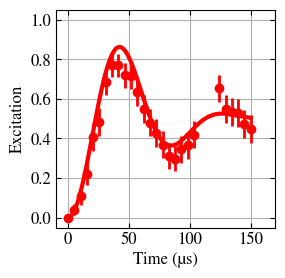

In [24]:
# Running simulation
# rabi =  fitted_rabi
rabi = fitted_rabi
nbar =  fitted_nbar
# n_ions = 9
# N = 400
nalpha = fitted_nalpha

# You already have these lines in your code
time = np.linspace(np.min(times), np.max(times), 200)

# Running simulation for different nalpha values
nbars = [nbar - 3, nbar, nbar + 3]
results = []

for nbar in nbars:
    D_population, _ = pe_model_optimized(time, rabi_0_fit=rabi, nbar_fit=nbar, nalpha_fit=nalpha)
    results.append(D_population)

import os
# Create outputs directory if it doesn't exist
os.makedirs("./outputs/shuttling/", exist_ok=True)

np.save("./data/save_rabi_t_shuttling_static.npy", rabi_t)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy", pmt_counts_avg_thresholded)
np.save("./data/save_rabi_t_shuttling_static_simulation.npy", time)
np.save("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy", results)

rabi_t = np.load("./data/save_rabi_t_shuttling_static.npy")
pmt_counts_avg_thresholded = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static.npy")
time = np.load("./data/save_rabi_t_shuttling_static_simulation.npy")
results = np.load("./data/save_pmt_counts_avg_thresholded_shuttling_static_simulation.npy")

# Plotting
plt.figure(figsize=(2.83, 2.83))
errorbar = np.sqrt(pmt_counts_avg_thresholded * (1 - pmt_counts_avg_thresholded)) / np.sqrt(n_samples)
plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='red', lw=2, zorder=2, label='Data')
# plt.scatter(rabi_t[:], pmt_counts_avg_thresholded[:], c='red', s=30, zorder=2, label='Data')
# plt.errorbar(rabi_t[:], pmt_counts_avg_thresholded[:], yerr=errorbar[:], fmt='o', c='C0', lw=1, zorder=2, label='Data')
plt.plot(time, results[1], c='red', lw=3, zorder=3, label=f'$\\bar{{n}}_{{th}} = {np.average(nbars):.1f} \\pm {(np.average(nbars) - nbars[0]):.1f}$')
plt.plot(time, results[0], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
plt.plot(time, results[2], '--', c='red', lw=0.5, zorder=1, alpha=0.1)
# plt.fill_between(time, results[0], results[2], color='red', alpha=0.3)
# plt.title('9-ion rabi oscillation after half speed shuttling', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.xlabel(r'Time (µs)', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylabel(r'Excitation', fontdict={'family': 'STIXGeneral', 'size': 12})
plt.ylim(-0.05, 1.05)
plt.xlim(-10, 170)
# plt.legend(loc='lower right')
# plt.legend()
plt.grid(True)
plt.savefig('./outputs/shuttling/Rabi_9_ions_no_shuttling.pdf', format='pdf', bbox_inches='tight')
plt.show()